# Using XGBoost with Oversampling

### Same setting up of the dataset

In [4]:
import pandas as pd
df = pd.read_csv('data/res_anon_working.csv')

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, 
                             precision_recall_fscore_support, 
                             average_precision_score, 
                             roc_auc_score, 
                             confusion_matrix,
                             precision_recall_curve)
import matplotlib.pyplot as plt
%matplotlib inline

#### Defining X and y

In [6]:
feat_lst = list(df)
feat_lst.pop(-1)
X = df[feat_lst]
y = df['Class']

#### Defining model evaluation functions

In [26]:
def model_eval(X, y, model):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(confusion_matrix(y, y_pred))
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print('Precision: %f' % (float(tp)/(tp + fp)))
    print('Recall: %f' % (float(tp)/(tp + fn)))
    y_proba = model.predict_proba(X)[:,1]
    print('AUC: %f' % roc_auc_score(y, y_proba))
# AUC under ROC curve should be using the probabilities of each sample instead of the actual label for each sample
# Hence, it must be using predict_proba and not predict

In [29]:
def pr_eval(X, y, model):
    y_proba = model.predict_proba(X)[:,1]
    average_precision = average_precision_score(y, y_proba)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    
    precision, recall, _ = precision_recall_curve(y, y_proba)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))


In [10]:
def graph_eval(X, y, model):
    p_range = np.arange(0.1, 1, 0.1) 
    p_range
    precisions = []
    recalls = []
    f1s = []
    prob_range = []
    # model.fit(X, y)

    pred = model.predict_proba(X)
    for p in p_range:

        pred_tmp = pred[:, 1].copy()
        pred_tmp[pred_tmp > p] = 1
        pred_tmp[pred_tmp <= p] = 0
        tn, fp, fn, tp = confusion_matrix(y, pred_tmp).ravel()
        if tp == 0: 
            continue
        prec = (float(tp)/(tp + fp))
        rec = (float(tp)/(tp + fn))
        f1 = 2 * prec * rec / (prec + rec)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        prob_range.append(p)

    # plot the results
    plt.plot(prob_range, precisions, 'k', label='Precision')
    plt.plot(prob_range, recalls, 'g', label='Recall')
    plt.plot(prob_range, f1s, 'b', label='F1')
    plt.xlabel('Prob Range')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1))

#### Similarly, let's split the dataset into training and testing set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)
# stratify=y splits up the dataset in a way that accounts for the representation of each response class
# i.e. proportion of '1' and '0' in y_train and y_test will be the same as the original dataset y
# note this method stratifies the dataset that is specified after 'stratify=', which in this is case, is y

### Let's try using XGBoost with naive over-sampling

In [12]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
ros = RandomOverSampler(random_state=0)
X_ros_resampled, y_ros_resampled = ros.fit_sample(X_train, y_train)
from collections import Counter
print sorted(Counter(y_ros_resampled).items())

[(0.0, 70046), (1.0, 70046)]


#### Fitting and evaluating the model

In [13]:
xgb = XGBClassifier(max_depth=5, n_estimators=5000)

In [14]:
xgb.fit(X_ros_resampled, y_ros_resampled)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=5000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [15]:
X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

[[16356  1156]
 [  351   224]]
Accuracy: 91.67%
Precision: 0.162319
Recall: 0.389565
AUC: 0.745583


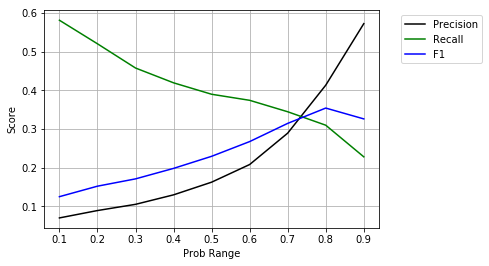

In [27]:
model_eval(X_test, y_test, xgb)
graph_eval(X_test, y_test, xgb)

Average precision-recall score: 0.25


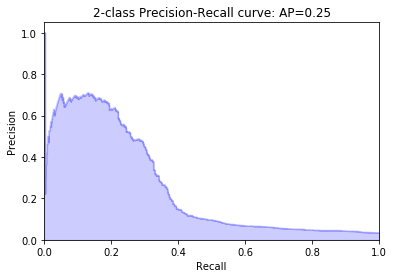

In [30]:
pr_eval(X_test, y_test, xgb)

Looking at this, I'm quite sure it's the lack of proper telling features from the dataset that's causing this bad performance of the algorithm. But before we call it a day, I'll try to tune the parameters of the XGBoost model to see where this goes!

### Upcoming updates:
* Tuning of the XGBoost parameters
* Utilizing undersampling methods to see the differences in the results of the models